In [1]:
import numpy as np
import pandas as pd
import nltk
from bs4 import BeautifulSoup
import re
import os
import codecs
from sklearn import feature_extraction
#import mpld3

In [23]:
df=pd.read_csv('../dump_cat2.csv')
X2=df.Short_description
Y2=df.Category
print(X2.shape)

(98223,)


In [66]:
df.Category.value_counts()

End User Services    24857
Application          23610
Security             19735
Server                9595
Network               7042
HelpDesk              6724
EAI Interface         2199
Telecom               2141
Human Resources        948
Storage                775
EAI Component          597
Name: Category, dtype: int64

In [101]:
X1 =df[df.Category=='End User Services'].Short_description
X2 =df[df.Category=='Application'].Short_description
X3 =df[df.Category=='Security'].Short_description
print(X1.shape,X2.shape)

(24857,) (23610,)


In [77]:
X3.head()

14     network---customer wanted his acc to be unlock...
20         Network account- locked || user id- djames003
101                                  Phishing simulation
110    network---customer wanted network password res...
184    Network account - login issue || user id- dmon...
Name: Short_description, dtype: object

In [102]:
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
stop = stopwords.words('english')
lemmer=WordNetLemmatizer()

def pre_process(X):
    pat = r'[^A-Za-z ]+'
    X = X.str.replace(pat, ' ',regex=True)
    X = X.apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
    X = X.apply(lambda x: ' '.join([lemmer.lemmatize(word) for word in x.split()]))
    return X

In [111]:
#X1 = pre_process(X1)
X2 = pre_process(X2)
print(X1[:5])
print(X2[:5])

27     WOW / Workstation on Wheels || WOW / Workstati...
93     Keyboard---  Few keys not working || Device id...
141                                Wow:Unable to turn on
256        Workstation - Needs monitiors to be added || 
260                     Clairvia - Not able to login || 
Name: Short_description, dtype: object
11     FW microviewer displaying antibiotic properly ...
52     MS phxasp unable login user id kquinteros TT a...
58     clairvia able login user id sgreen Loc Bakersf...
114        nmscust fw data mdf main mdm b Network Outage
115          nmscust fw data mdf main mdm Network Outage
Name: Short_description, dtype: object


In [7]:
# load nltk's English stopwords as variable called 'stopwords'
stopwords = nltk.corpus.stopwords.words('english')
# load nltk's SnowballStemmer as variabled 'stemmer'
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")

In [5]:
# here I define a tokenizer and stemmer which returns the set of stems in the text that it is passed

def tokenize_and_stem(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems


def tokenize_only(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens

#  tf-idf

In [112]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer( max_features=5000,
                                  stop_words='english',
                                  use_idf=True, tokenizer=tokenize_only, ngram_range=(1,3))

%time tfidf_matrix = tfidf_vectorizer.fit_transform(X2.values.astype('U'))

print(tfidf_matrix.shape)

Wall time: 5.91 s
(23610, 5000)


In [113]:
from sklearn.cluster import KMeans

num_clusters = 10
km = KMeans(n_clusters=num_clusters)
%time km.fit(tfidf_matrix)
clusters = km.labels_.tolist()



Wall time: 1min 48s


In [114]:
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
terms = tfidf_vectorizer.get_feature_names()
    
for i in range(num_clusters):
    print("Cluster %d:" % i, end='')
    #terms_map['index'] = i
    list = [] 
    for ind in order_centroids[i, :20]:
        print(' %s' % terms[ind], end=',')

    print()

Cluster 0: error, getting, communication, unable, getting error, error message, message, id, error communication, login error, gecb, ms, exception, dev, unable login error, ms error, device, dev id, login, error dev,
Cluster 1: unable login, login, unable, login username, unable login username, username, ms unable login, ms unable, ms, phxasp, id, axway, unable login dev, ess unable login, ess unable, login dev, ess, login dev id, unable login userid, login userid,
Cluster 2: reset, password, password reset, hduv, reset user, password reset user, user, need password, need password reset, login, need, reset password, reset user id, user id, issue, id, hduv reset, hduv password, resolved, hduv password reset,
Cluster 3: account, locked, account locked, ii, locked user, user, ms, account locked user, user id, ms account, unlocked, id, locked user id, resolved, login account, login account locked, issue resolved, issue, ms account locked, unlocked account,
Cluster 4: cerner, powerchart, ce

In [100]:
true_k = num_clusters
terms_map = pd.DataFrame(index=np.arange(0, true_k),columns=['terms'])
#terms_map['data_index'] = X3.index.values
#terms_map['cluster'] = km.labels_

if not opts.use_hashing:
    print("Top terms per cluster:")

    if opts.n_components:
        original_space_centroids = svd.inverse_transform(km.cluster_centers_)
        order_centroids = original_space_centroids.argsort()[:, ::-1]
    else:
        order_centroids = km.cluster_centers_.argsort()[:, ::-1]

    terms = tfidf_vectorizer.get_feature_names()
    
    for i in range(true_k):
        print("Cluster %d:" % i, end='')
        #terms_map['index'] = i
        list = [] 
        for ind in order_centroids[i, :20]:
            print(' %s' % terms[ind], end=',')
        
        for ind in order_centroids[i, :100]:
            list.append(terms[ind])
        str = ', '.join(list) 
        terms_map.iloc[i] = str
        print()
#print(terms_map.shape)

Top terms per cluster:
Cluster 0: date, notification text, text, notification, amcore date, amcore, text amcore, notification text amcore, text amcore date, ticket new event, secureworks ticket, secureworks, disruption, disruption security, new event, disruption security ct, security ct, flow disruption security, flow disruption, flow,
Cluster 1: network unable login, network unable, unable login username, login username, unable login, unable, login, username, network, acc, unlocked acc, unlocked, unable login network, unable login user, hduv, login network, login user, hduv password, hduv password reset, id,
Cluster 2: account locked, locked, account, account locked user, locked user, network account locked, locked user id, network account, network, unlocked, user, unable login account, unlocked account, login account locked, user id, login account, id, account locked username, locked username, account account locked,
Cluster 3: login, user, unable, id, account, network, unable login,

#Security - Top terms

In [99]:
#all terms in cluster index
#print(terms_map.terms[0])

In [91]:
cluster_map = pd.DataFrame()
cluster_map['data_index'] = X4.index.values
cluster_map['cluster'] = km.labels_

In [92]:
cluster_map['cluster'].value_counts()

44    3422
1      999
20     976
9      686
14     685
36     641
13     619
12     612
11     585
41     549
8      508
49     497
10     478
15     454
2      425
3      389
19     377
46     376
4      352
7      330
28     300
43     298
34     291
17     256
32     251
21     245
35     244
40     241
6      221
5      220
26     216
25     214
30     214
42     207
16     202
22     201
23     193
37     192
48     180
45     175
27     161
31     145
47     143
0      135
24     128
38     124
39     109
18      96
33      91
29      82
Name: cluster, dtype: int64

In [32]:
import logging
from optparse import OptionParser
import sys
from time import time

# Display progress logs on stdout
#logging.basicConfig(level=logging.INFO,
#                    format='%(asctime)s %(levelname)s %(message)s')

# parse commandline arguments
op = OptionParser()
op.add_option("--lsa",
              dest="n_components", type="int",
              help="Preprocess documents with latent semantic analysis.")
op.add_option("--no-minibatch",
              action="store_false", dest="minibatch", default=True,
              help="Use ordinary k-means algorithm (in batch mode).")
op.add_option("--no-idf",
              action="store_false", dest="use_idf", default=True,
              help="Disable Inverse Document Frequency feature weighting.")
op.add_option("--use-hashing",
              action="store_true", default=False,
              help="Use a hashing feature vectorizer")
op.add_option("--n-features", type=int, default=10000,
              help="Maximum number of features (dimensions)"
                   " to extract from text.")
op.add_option("--verbose",
              action="store_true", dest="verbose", default=False,
              help="Print progress reports inside k-means algorithm.")

print(__doc__)
op.print_help()


def is_interactive():
    return not hasattr(sys.modules['__main__'], '__file__')

# work-around for Jupyter notebook and IPython console
argv = [] if is_interactive() else sys.argv[1:]
(opts, args) = op.parse_args(argv)
if len(args) > 0:
    op.error("this script takes no arguments.")
    sys.exit(1)


Automatically created module for IPython interactive environment
Usage: ipykernel_launcher.py [options]

Options:
  -h, --help            show this help message and exit
  --lsa=N_COMPONENTS    Preprocess documents with latent semantic analysis.
  --no-minibatch        Use ordinary k-means algorithm (in batch mode).
  --no-idf              Disable Inverse Document Frequency feature weighting.
  --use-hashing         Use a hashing feature vectorizer
  --n-features=N_FEATURES
                        Maximum number of features (dimensions) to extract
                        from text.
  --verbose             Print progress reports inside k-means algorithm.


In [46]:
#strip any proper nouns (NNP) or plural proper nouns (NNPS) from a text
from nltk.tag import pos_tag

def strip_proppers_POS(text):
    tagged = pos_tag(text.split()) #use NLTK's part of speech tagger
    non_propernouns = [word for word,pos in tagged if pos != 'NNP' and pos != 'NNPS']
    return non_propernouns

# Hierarchical document clustering -wip

KeyError: -59

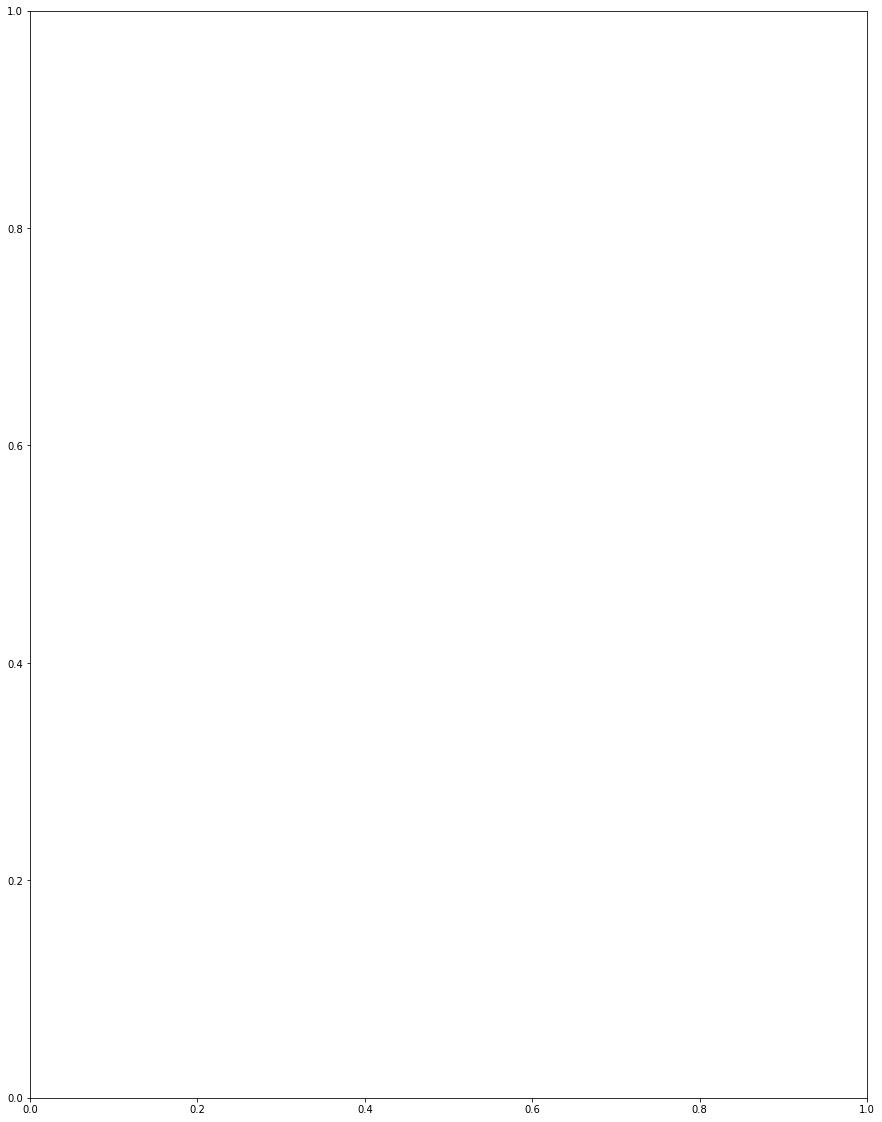

In [137]:
from scipy.cluster.hierarchy import ward, dendrogram

linkage_matrix = ward(dist) #define the linkage_matrix using ward clustering pre-computed distances

fig, ax = plt.subplots(figsize=(15, 20)) # set size
ax = dendrogram(linkage_matrix, orientation="right", labels=X2);

plt.tick_params(\
    axis= 'x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off')

plt.tight_layout() #show plot with tight layout

#uncomment below to save figure
plt.savefig('ward_clusters.png', dpi=200) #save figure as ward_clusters

In [52]:
plt.close()

# Latent Dirichlet Allocation

In [53]:
#strip any proper names from a text...unfortunately right now this is yanking the first word from a sentence too.
import string
def strip_proppers(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent) if word.islower()]
    return "".join([" "+i if not i.startswith("'") and i not in string.punctuation else i for i in tokens]).strip()

In [54]:
#strip any proper nouns (NNP) or plural proper nouns (NNPS) from a text
from nltk.tag import pos_tag

def strip_proppers_POS(text):
    tagged = pos_tag(text.split()) #use NLTK's part of speech tagger
    non_propernouns = [word for word,pos in tagged if pos != 'NNP' and pos != 'NNPS']
    return non_propernouns

In [55]:
#Latent Dirichlet Allocation implementation with Gensim

from gensim import corpora, models, similarities 

#remove proper names
preprocess = [strip_proppers(doc) for doc in X3]

%time tokenized_text = [tokenize_and_stem(text) for text in preprocess]

%time texts = [[word for word in text if word not in stopwords] for text in tokenized_text]

C:\Users\124578\AppData\Local\Continuum\anaconda2\envs\py36\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


Wall time: 3.75 s
Wall time: 359 ms


In [56]:
#print(len([word for word in texts[0] if word not in stopwords]))
print(len(texts[0]))

1839


In [57]:
dictionary = corpora.Dictionary(texts)

In [58]:
dictionary.filter_extremes(no_below=1, no_above=0.8)

In [59]:
corpus = [dictionary.doc2bow(text) for text in texts]

In [60]:
len(corpus)

100

In [61]:
%time lda = models.LdaModel(corpus, num_topics=5, id2word=dictionary, update_every=5, chunksize=10000, passes=100)

Wall time: 38.7 s


In [62]:
print(lda[corpus[0]])

[(1, 0.017235748), (2, 0.91388589), (4, 0.0686308)]


In [63]:
topics = lda.print_topics(5, num_words=20)

In [64]:
topics_matrix = lda.show_topics(formatted=False, num_words=20)

In [71]:
for idx, topic in lda.show_topics(formatted=False, num_words= 20):
    print('Topic: {} \nWords: {}'.format(idx, [w[0] for w in topic]))

Topic: 0 
Words: ['father', 'home', 'meet', 'kill', 'two', 'ship', 'go', 'friend', 'use', 'car', 'ask', 'love', 'come', 'call', 'away', 'want', 'explain', 'becom', 'marri', 'day']
Topic: 1 
Words: ['kill', 'go', 'men', 'friend', "n't", 'ask', 'day', 'call', 'home', 'night', 'say', 'soldier', 'goe', 'doe', 'arriv', 'two', 'run', 'fight', 'want', 'work']
Topic: 2 
Words: ['famili', 'polic', 'kill', 'meet', 'apart', 'car', 'ask', 'father', 'help', 'two', 'say', 'home', 'train', 'go', "n't", 'murder', 'friend', 'mother', 'live', 'away']
Topic: 3 
Words: ['first', 'film', 'run', 'night', 'train', 'town', 'live', 'arriv', 'love', 'two', 'say', 'kill', 'peopl', 'go', 'home', 'come', 'becom', 'end', 'later', 'board']
Topic: 4 
Words: ['kill', 'arriv', 'famili', 'ask', 'meet', 'say', 'offic', 'friend', "n't", 'way', 'fight', 'men', 'order', 'die', 'shoot', 'help', 'murder', 'name', 'death', 'two']


In [70]:
for i in  lda_model.show_topics():
    print (i[0], i[1])

SyntaxError: Missing parentheses in call to 'print'. Did you mean print(int i[0], i[1])? (<ipython-input-70-e7b1c66babbc>, line 2)

In [68]:
print(topics_matrix)

[(0, [('father', 0.004311441), ('home', 0.0042508231), ('meet', 0.0040116757), ('kill', 0.0035479241), ('two', 0.0035385143), ('ship', 0.0034096707), ('go', 0.0033582922), ('friend', 0.0033297837), ('use', 0.0033122564), ('car', 0.0032725935), ('ask', 0.0032428596), ('love', 0.0031420384), ('come', 0.0029864861), ('call', 0.002836725), ('away', 0.0027618436), ('want', 0.0027208736), ('explain', 0.0026963295), ('becom', 0.0026955884), ('marri', 0.0026336494), ('day', 0.0026115484)]), (1, [('kill', 0.0046682791), ('go', 0.0043234131), ('men', 0.0042370837), ('friend', 0.0041060313), ("n't", 0.004100014), ('ask', 0.0039702337), ('day', 0.0038448663), ('call', 0.0038169932), ('home', 0.0035325803), ('night', 0.0035275053), ('say', 0.0035191469), ('soldier', 0.0035141041), ('goe', 0.0033807023), ('doe', 0.0033178746), ('arriv', 0.0032430789), ('two', 0.0031804519), ('run', 0.0031299402), ('fight', 0.0031237982), ('want', 0.003110538), ('work', 0.0029915068)]), (2, [('famili', 0.0062185777),

In [65]:
topics_matrix = np.array(topics_matrix)

ValueError: setting an array element with a sequence

In [66]:
topics_matrix.shape

AttributeError: 'list' object has no attribute 'shape'

In [67]:
topic_words = topics_matrix[:,:,1]

TypeError: list indices must be integers or slices, not tuple

In [ ]:
for i in topic_words:
    print([str(word) for word in i])
    print()

In [75]:
#Deep learning
from keras.engine.topology import Layer, InputSpec
from keras.layers import Dense, Input
from keras.models import Model
from keras.optimizers import SGD
from keras import callbacks
from keras.initializers import VarianceScaling

Using TensorFlow backend.


In [74]:
tfidf_matrix.shape

(100, 563)

# Other methods


In [87]:
# this is our input placeholder
input_img = Input(shape=(563,))

# "encoded" is the encoded representation of the input
encoded = Dense(500, activation='relu')(input_img)
encoded = Dense(500, activation='relu')(encoded)
encoded = Dense(2000, activation='relu')(encoded)
encoded = Dense(10, activation='sigmoid')(encoded)

# "decoded" is the lossy reconstruction of the input
decoded = Dense(2000, activation='relu')(encoded)
decoded = Dense(500, activation='relu')(decoded)
decoded = Dense(500, activation='relu')(decoded)
decoded = Dense(563)(decoded)

# this model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)

In [88]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 563)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 500)               282000    
_________________________________________________________________
dense_10 (Dense)             (None, 500)               250500    
_________________________________________________________________
dense_11 (Dense)             (None, 2000)              1002000   
_________________________________________________________________
dense_12 (Dense)             (None, 10)                20010     
_________________________________________________________________
dense_13 (Dense)             (None, 2000)              22000     
_________________________________________________________________
dense_14 (Dense)             (None, 500)               1000500   
__________

In [90]:
autoencoder.compile(optimizer='adam', loss='mse')

In [91]:
train_history = autoencoder.fit(tfidf_matrix, tfidf_matrix, epochs=500, batch_size=2048)

Epoch 1/500


ValueError: setting an array element with a sequence.

In [ ]:
pred_auto_train = encoder.predict(train_x)
pred_auto = encoder.predict(val_x)

In [ ]:
km.fit(pred_auto_train)
pred = km.predict(pred_auto)

In [80]:
from sklearn.metrics import accuracy_score, normalized_mutual_info_score

In [ ]:
normalized_mutual_info_score(val_y, pred)